In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/AI/ai4vn_2020/Workshop-2020.zip"

Archive:  /content/drive/MyDrive/AI/ai4vn_2020/Workshop-2020.zip
   creating: Workshop/
  inflating: Workshop/readme.txt     
   creating: Workshop/sample_data/
   creating: Workshop/sample_data/1/
  inflating: Workshop/sample_data/1/002004.png  
  inflating: Workshop/sample_data/1/002005.png  
  inflating: Workshop/sample_data/1/002006.jpeg  
  inflating: Workshop/sample_data/1/002009.png  
  inflating: Workshop/sample_data/1/002013.png  
  inflating: Workshop/sample_data/1/002014.png  
  inflating: Workshop/sample_data/1/002016.jpeg  
  inflating: Workshop/sample_data/1/002019.png  
  inflating: Workshop/sample_data/1/002020.jpeg  
  inflating: Workshop/sample_data/1/002021.jpeg  
  inflating: Workshop/sample_data/1/002022.png  
  inflating: Workshop/sample_data/1/002023.jpg  
  inflating: Workshop/sample_data/1/002024.jpg  
  inflating: Workshop/sample_data/1/002055.jpg  
  inflating: Workshop/sample_data/1/002067.jpg  
  inflating: Workshop/sample_data/1/002069.jpg  
  inflating: W



# Tổng quan

Hướng dẫn này dựa trên hướng dẫn [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
!cp "/content/drive/MyDrive/AI/ai4vn_2020/dataloader.py" .
import dataloader
from dataloader import image_dataset_from_directory

## Tiền xử lý dữ liệu

### Tải dữ liệu

In [4]:


path_to_data = "/content/Workshop/sample_data"


BATCH_SIZE = 32
IMG_SIZE = (128, 128)

NUM_CLASS = 6

train_dataset, train_dataset_filenames = image_dataset_from_directory(path_to_data,
                                             validation_split=0.2,
                                             subset="training",
                                             shuffle=True,
                                             seed=505,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 300 files belonging to 6 classes.
Using 240 files for training.


In [5]:
validation_dataset, validation_dataset_filenames = image_dataset_from_directory(path_to_data,
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  shuffle=True,
                                                  seed=42,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 300 files belonging to 6 classes.
Using 60 files for validation.


In [6]:
test_dataset, test_dataset_filenames = image_dataset_from_directory('/content/Workshop/test_data',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 60 files belonging to 6 classes.


In [7]:
validation_dataset.class_names

['1', '2', '3', '4', '5', '6']

Hiển thị 9 hình ảnh và nhãn đầu tiên từ bộ huấn luyện:

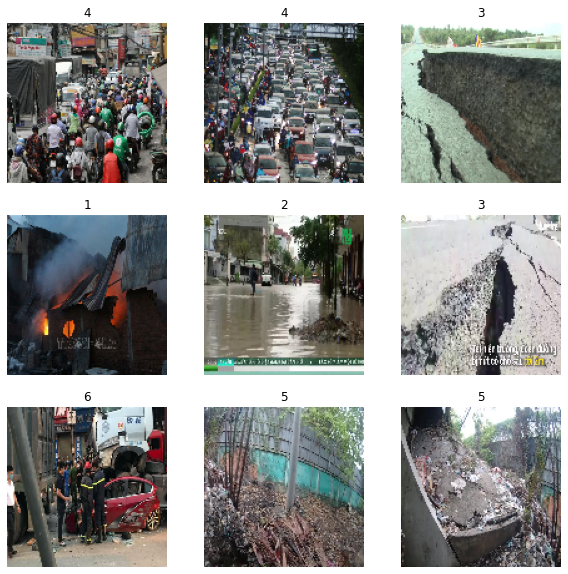

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Định cấu hình cho tập dữ liệu

Sử dụng tìm nạp trước có bộ đệm để tải hình ảnh từ đĩa mà không bị chặn I / O. Xem thêm tại [data performance](https://www.tensorflow.org/guide/data_performance).
Các câu lệnh dưới giúp tối ưu hiệu năng khi chạy bằng GPU

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)



### Sử dụng tăng cường dữ liệu

Khi dữ liệu ảnh không đủ lớn, bạn có thể tăng tính đa dạng của các mẫu dữ liệu bằng cách áp các phép biến đổi ngẫu nhiên. Điều này giúp giảm [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). Bạn có thể tìm hiểu thêm về tăng dữ liệu trong [hướng dẫn](https://www.tensorflow.org/tutorials/images/data_augmentation) này.

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Dưới đây là kết quả của việc tăng cường dữ liệu trên một tấm ảnh.

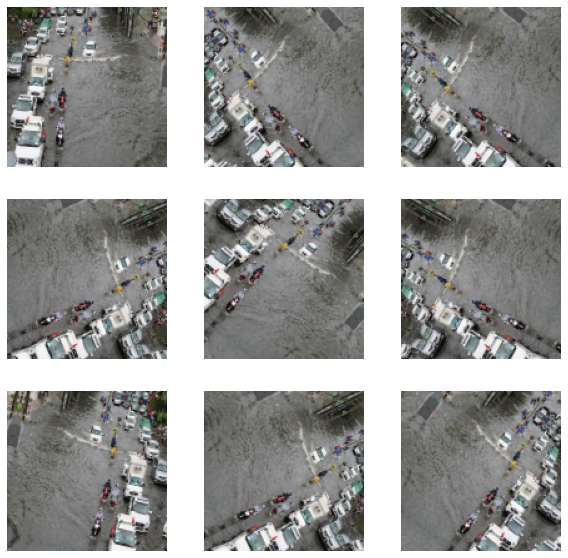

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
#rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


## lấy model đã train
có thể sử dụng những model có sẵn khác đã được công bố tại đường dẫn sau: https://keras.io/api/applications/


In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

(128, 128, 3)
9412608/9406464 [==============================] - 0s 0us/step



Mô hình trích xuất đặc trưng này nhận tấm ảnh với kích thước `128x128x3` chuyển thành đặc trưng `4x4x1280`

In [16]:
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape)
print(label_batch)
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 128, 128, 3)
tf.Tensor([0 2 2 1 0 5 3 0 0 1 4 3 4 4 0 5 2 3 4 0 3 0 0 2 3 2 1 4 2 1 1 1], shape=(32,), dtype=int32)
(32, 4, 4, 1280)


## Feature extraction

### Giữ nguyên các lớp CNN trong model


In [17]:
base_model.trainable = False

In [18]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Thêm 1 lớp phân loại vào

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
NUM_CLASS = 6
prediction_layer = tf.keras.layers.Dense(NUM_CLASS)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


In [21]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model


In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [24]:
len(model.trainable_variables)

2

### Train the model


In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

2/2 [==============================] - 2s 155ms/step - loss: 1.9252 - accuracy: 0.1951


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.93
initial accuracy: 0.18


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
8/8 [==============================] - 6s 156ms/step - loss: 2.4432 - accuracy: 0.1917 - val_loss: 1.7788 - val_accuracy: 0.2500
Epoch 2/10
8/8 [==============================] - 3s 104ms/step - loss: 2.1909 - accuracy: 0.2208 - val_loss: 1.6756 - val_accuracy: 0.2500
Epoch 3/10
8/8 [==============================] - 3s 104ms/step - loss: 2.1486 - accuracy: 0.2167 - val_loss: 1.6073 - val_accuracy: 0.3000
Epoch 4/10
8/8 [==============================] - 3s 104ms/step - loss: 2.0719 - accuracy: 0.2583 - val_loss: 1.5461 - val_accuracy: 0.3667
Epoch 5/10
8/8 [==============================] - 3s 104ms/step - loss: 1.9836 - accuracy: 0.2625 - val_loss: 1.4907 - val_accuracy: 0.4000
Epoch 6/10
8/8 [==============================] - 3s 105ms/step - loss: 1.7487 - accuracy: 0.3167 - val_loss: 1.4364 - val_accuracy: 0.4167
Epoch 7/10
8/8 [==============================] - 3s 105ms/step - loss: 1.8221 - accuracy: 0.3250 - val_loss: 1.3873 - val_accuracy: 0.4500
Epoch 8/10
8/8 [====

### Learning curves


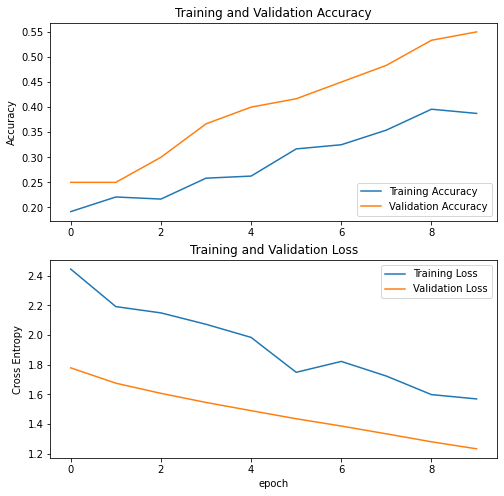

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Tinh Chỉnh


## Cho phép các lớp ở trên được train


In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model



In [31]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [33]:
len(model.trainable_variables)

56

### Tiếp tục train model

In [42]:
fine_tune_epochs = 10
total_epochs =  60

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         batch_size = 16)

Epoch 10/60
8/8 [==============================] - 3s 115ms/step - loss: 0.0984 - accuracy: 0.9625 - val_loss: 0.4666 - val_accuracy: 0.8667
Epoch 11/60
8/8 [==============================] - 3s 115ms/step - loss: 0.0582 - accuracy: 0.9958 - val_loss: 0.4425 - val_accuracy: 0.8667
Epoch 12/60
8/8 [==============================] - 3s 110ms/step - loss: 0.0808 - accuracy: 0.9708 - val_loss: 0.4786 - val_accuracy: 0.8500
Epoch 13/60
8/8 [==============================] - 3s 110ms/step - loss: 0.1007 - accuracy: 0.9708 - val_loss: 0.4273 - val_accuracy: 0.8667
Epoch 14/60
8/8 [==============================] - 3s 110ms/step - loss: 0.0721 - accuracy: 0.9792 - val_loss: 0.4626 - val_accuracy: 0.8667
Epoch 15/60
8/8 [==============================] - 3s 108ms/step - loss: 0.0791 - accuracy: 0.9708 - val_loss: 0.4777 - val_accuracy: 0.8667
Epoch 16/60
8/8 [==============================] - 3s 115ms/step - loss: 0.0676 - accuracy: 0.9833 - val_loss: 0.4860 - val_accuracy: 0.8500
Epoch 17/60


KeyboardInterrupt: ignored

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

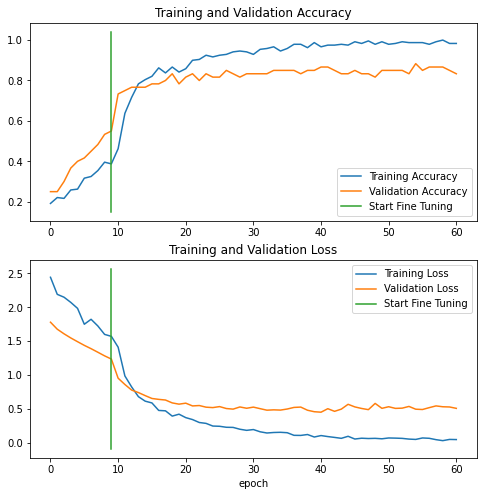

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Tiến hành đánh giá model và dự đoán

In [37]:
loss, accuracy = model.evaluate(validation_dataset)
print('Validation accuracy :', accuracy)

2/2 [==============================] - 1s 21ms/step - loss: 0.4482 - accuracy: 0.8667
Validation accuracy : 0.8666666746139526


Predictions:
 [1 0 2 4 2 4 3 0 5 5 1 2 5 4 4 4 3 2 5 4 0 4 4 2 4 5 5 1 5 5 1 5]
Labels:
 [3 0 2 4 2 4 3 0 5 3 1 2 5 4 4 4 5 1 5 4 0 4 4 2 4 5 4 1 5 5 1 5]


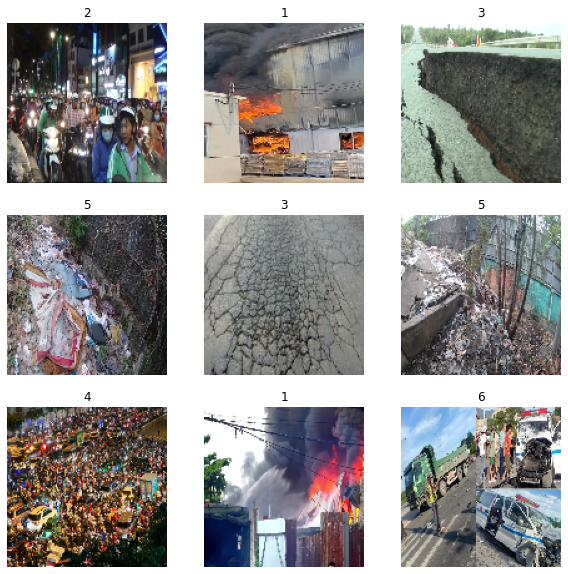

In [38]:
#Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predicted_class = np.argmax(predictions, axis=-1)


print('Predictions:\n', predicted_class)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predicted_class[i]])
  plt.axis("off")

In [39]:
predictions = model.predict(test_dataset)

predicted_class = np.argmax(predictions, axis=-1)


print('Predictions:\n', predicted_class)

Predictions:
 [5 1 1 5 0 1 4 0 5 5 5 1 2 3 1 4 5 0 1 2 5 3 1 1 2 2 1 2 4 0 1 3 5 5 5 3 1
 3 5 2 2 3 5 0 3 4 4 0 4 3 5 1 5 0 2 5 0 5 5 0]


In [40]:
with open('submission.txt', 'w') as submission_file:
  for filename, predicted in zip(test_dataset_filenames, predicted_class):
    submission_file.write('{}\t{}\n'.format(filename.split('/')[-1], class_names[predicted]))

In [41]:
model_name = 'ModelMobinetV2.h5'
save_path= '/content/'+model_name
model.save(save_path)